In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D, Conv1D
from keras.models import Model
from sklearn.model_selection import train_test_split
import copy

In [36]:
# load data
Xdata = np.load('/kaggle/input/hyperspectral-atmospheric-compensation/Xdata_tiny.npy') # data with the "noise" of the atmosphere
Ydata = np.load('/kaggle/input/hyperspectral-atmospheric-compensation/Ydata_tiny.npy')
wl = np.load('/kaggle/input/hyperspectral-atmospheric-compensation/wl.npy')
nObs, nSpec, nBands = Xdata.shape

In [15]:
# lets chape the shape of each of these:
print('Xdata shape: '+str(Xdata.shape))
print('Ydata shape: '+str(Ydata.shape))
print('wl shape: '+str(wl.shape))
print('Number of bands: '+str(nObs))
print('Number of Spectra: '+str(nSpec))
print('Number bands in each spectrum: '+str(nBands))

Xdata shape: (10000, 40, 452)
Ydata shape: (10000, 40, 452)
wl shape: (452,)
Number of bands: 10000
Number of Spectra: 40
Number bands in each spectrum: 452


Xdata is an array with 10,000 observations.

Each observation is a group of 40 spectra, and each spectrum has 452 wavelengths.

Each of the observations in Xdata is in radiance units (what a sensor measures with the atmosphere). Each observation in yData is in reflectance units (representing the reflectance off the ground from the materials, with the atmoshpere removed).

In [37]:
# data for validation
X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Ydata, test_size=0.33, random_state=42)

# scaling input data (I am not sure why we do this - just following other autoencoder demos)
X_train = X_train.reshape([-1,nSpec,nBands,1])
X_test = X_test.reshape([-1,nSpec,nBands,1])
Y_train = Y_train.reshape([-1,nSpec,nBands,1])
Y_test = Y_test.reshape([-1,nSpec,nBands,1])

We feed a single observation into the autoencoder.  The observation is 40 spectra, which represents what you would get from 40 pixels in an image.  We feed it into the autoencoder as an array of 40x542.  Here are some plots of diffferent ways we can view each observation - either as a 40x452 array as an image (the images that look like red stripes) or as a plot of 40 spectra (the second set of plots).

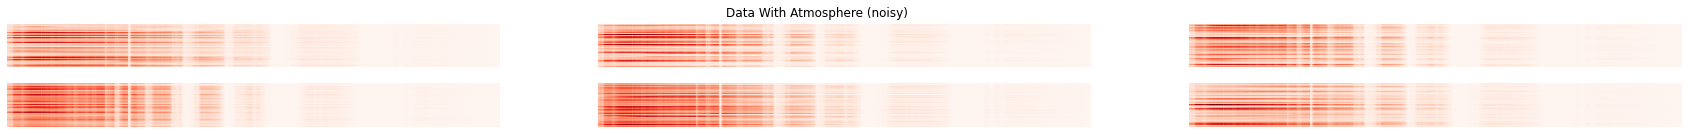

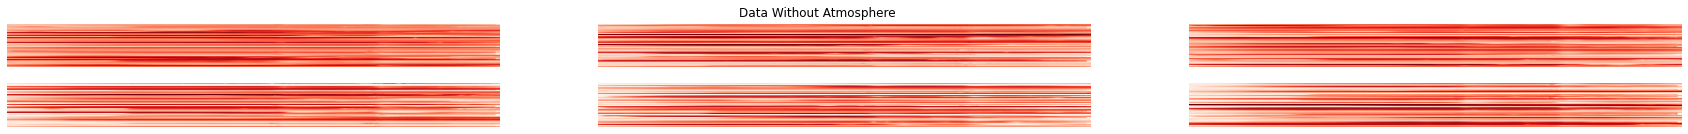

In [5]:
# view noisy (with atmosphere) data as images
rows = 2 # defining no. of rows in figure
cols = 3 # defining no. of colums in figure
f = plt.figure(figsize=(10*cols,rows)) # defining a figure
for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(X_train[i].reshape([nSpec,nBands]),cmap="Reds")
    plt.axis("off")
plt.suptitle("Data With Atmosphere (noisy)");

f = plt.figure(figsize=(10*cols, rows)) # defining a figure
for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(Y_train[i].reshape([nSpec,nBands]),cmap="Reds")
    plt.axis("off")
plt.suptitle("Data Without Atmosphere");

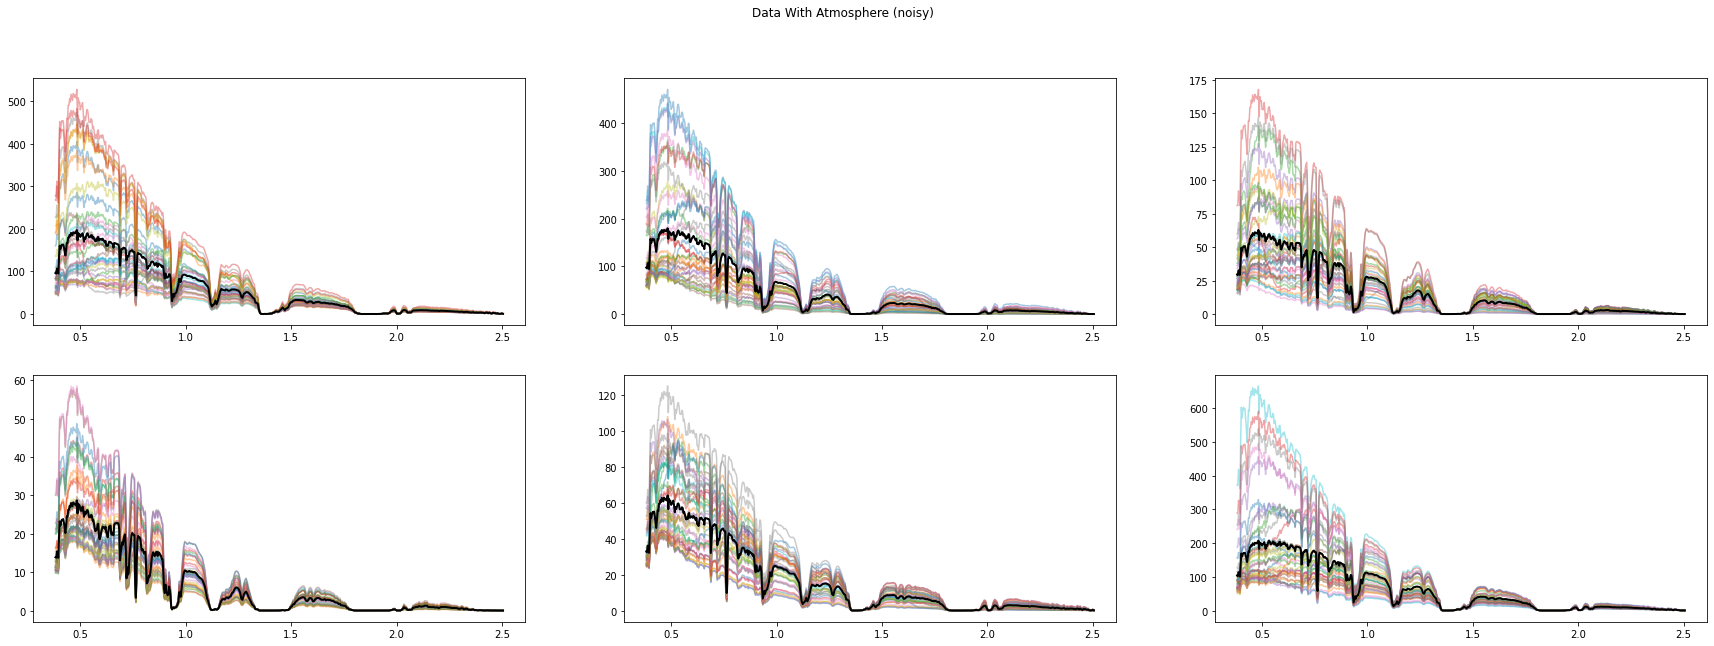

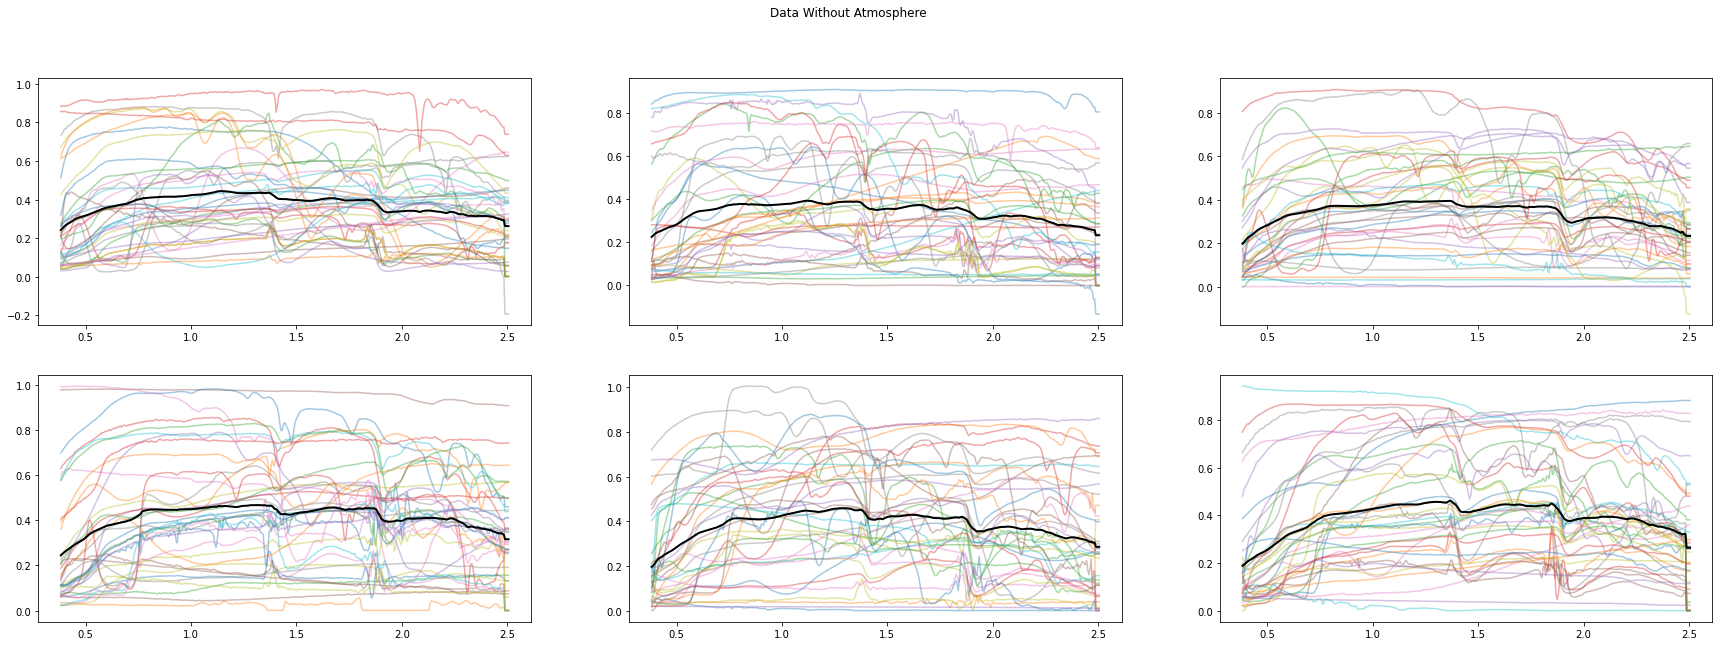

In [6]:
# view noisy (with atmosphere) data as plots of spectra
# the 41st spectra is the mean spectra in each, plotted in black
rows = 2 # defining no. of rows in figure
cols = 3 # defining no. of colums in figure
f = plt.figure(figsize=(10*cols,5*rows)) # defining a figure
for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.plot(wl, X_train[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, X_train[i,nSpec-1,:,:].flatten(), color='k', linewidth=2)
plt.suptitle("Data With Atmosphere (noisy)");

f = plt.figure(figsize=(10*cols, 5*rows)) # defining a figure
for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.plot(wl, Y_train[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, Y_train[i,nSpec-1,:,:].flatten(), color='k', linewidth=2)
plt.suptitle("Data Without Atmosphere");

# Autoencoder part, using something from other work:

I was trying to mimick this:
https://www.kaggle.com/tarunkr/autoencoder-denoising-image-mnist-cifar10

But maybe something like on of these:
https://keras.io/examples/vision/autoencoder/
or:
https://www.analyticsvidhya.com/blog/2021/07/image-denoising-using-autoencoders-a-beginners-guide-to-deep-learning-project/

In [7]:
# Define the Auto Encoder

# Encoder
inputs = Input(shape=(nSpec,nBands,1))
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(x)
x = Dropout(0.005)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2D(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D()(x)
x = Dropout(0.005)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder.summary()

2022-02-05 21:45:06.025917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 452, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 452, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 226, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 226, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 226, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 113, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 113, 32)       9248  

2022-02-05 21:45:06.107392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 21:45:06.108082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 21:45:06.109469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-05 21:45:06.110505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
# Training
epochs = 100
batch_size = 256
history = autoencoder.fit(X_train,
                Y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, Y_test)
               )

2022-02-05 21:45:08.551991: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 484544000 exceeds 10% of free system memory.
2022-02-05 21:45:09.229211: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 484544000 exceeds 10% of free system memory.
2022-02-05 21:45:09.743790: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 484544000 exceeds 10% of free system memory.
2022-02-05 21:45:10.091377: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 484544000 exceeds 10% of free system memory.
2022-02-05 21:45:10.477797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-02-05 21:45:11.963416: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27/27 [==============================] - 13s 215ms/step - loss: 1.0091 - val_loss: 0.6670
Epoch 2/100
27/27 [==============================] - 4s 141ms/step - loss: 0.6714 - val_loss: 0.8620
Epoch 3/100
27/27 [==============================] - 4s 140ms/step - loss: 0.6642 - val_loss: 0.6460
Epoch 4/100
27/27 [==============================] - 4s 139ms/step - loss: 0.6485 - val_loss: 0.6637
Epoch 5/100
27/27 [==============================] - 4s 140ms/step - loss: 0.6392 - val_loss: 0.6382
Epoch 6/100
27/27 [==============================] - 4s 140ms/step - loss: 0.6329 - val_loss: 0.6205
Epoch 7/100
27/27 [==============================] - 4s 140ms/step - loss: 0.6264 - val_loss: 0.6149
Epoch 8/100
27/27 [==============================] - 4s 140ms/step - loss: 0.6192 - val_loss: 0.6235
Epoch 9/100
27/27 [==============================] - 4s 141ms/step - loss: 0.6128 - val_loss: 0.6081
Epoch 10/100
27/27 [==============================] - 4s 139ms/step - loss: 0.6101 - val_loss: 0.6063


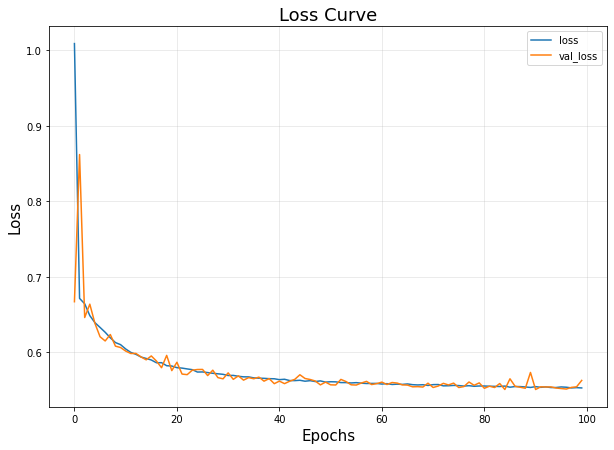

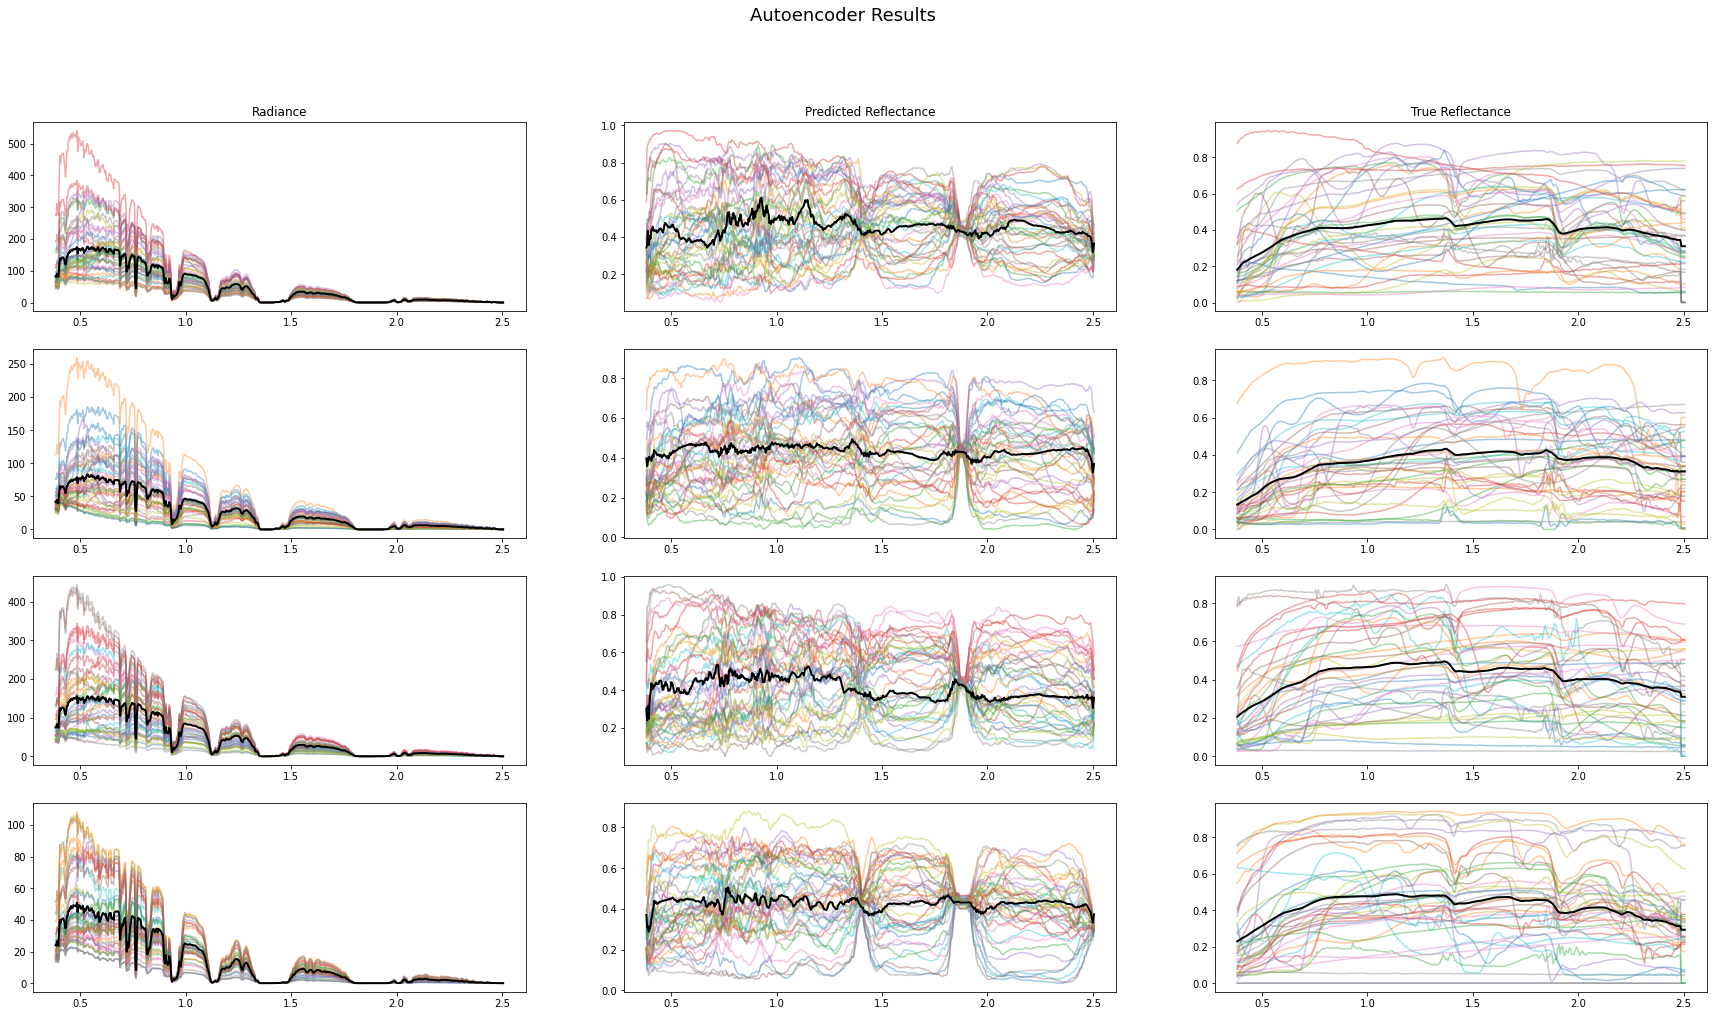

In [9]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set
plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve.png")
plt.show()


# Select few random test images
num_imgs = 4
rand = np.random.randint(1, 100)
test_X = X_test[rand:rand+num_imgs] # slicing
test_Y = Y_test[rand:rand+num_imgs]
test_X_reflectance = autoencoder.predict(test_X) # predict

# Visualize test images with their denoised images
rows = 4  # defining no. of rows in figure
cols = 3  # defining no. of colums in figure
f = plt.figure(figsize=(10 * cols, 2 * rows * 2))  # defining a figure
for i in range(rows):
    f.add_subplot(4,3,i*cols+1)  # adding sub plot to figure on each iteration
    #plt.imshow(test_images[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_X[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_X[i,nSpec-1,:,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('Radiance')

    f.add_subplot(4,3,i*cols+2)  # adding sub plot to figure on each iteration
    #plt.imshow(test_desnoised[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_X_reflectance[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_X_reflectance[i,nSpec-1,:,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('Predicted Reflectance')

    f.add_subplot(4,3,i*cols+3)  # adding sub plot to figure on each iteration
    #plt.imshow(test_desnoised[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_Y[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_Y[i,nSpec-1,:,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('True Reflectance')

f.suptitle("Autoencoder Results", fontsize=18)
plt.savefig("test_results.png")

plt.show()

# SImple Regression Method

In [38]:
# We have to reformat the data shape from the previous - just removing an extra column
X_test = X_test[:,:,:,0]
Y_test = Y_test[:,:,:,0]
X_train = X_train[:,:,:,0]
Y_train = Y_train[:,:,:,0]
print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)

(3300, 40, 452)
(3300, 40, 452)
(6700, 40, 452)
(6700, 40, 452)


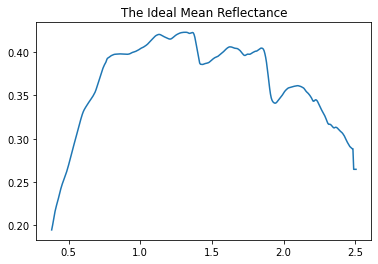

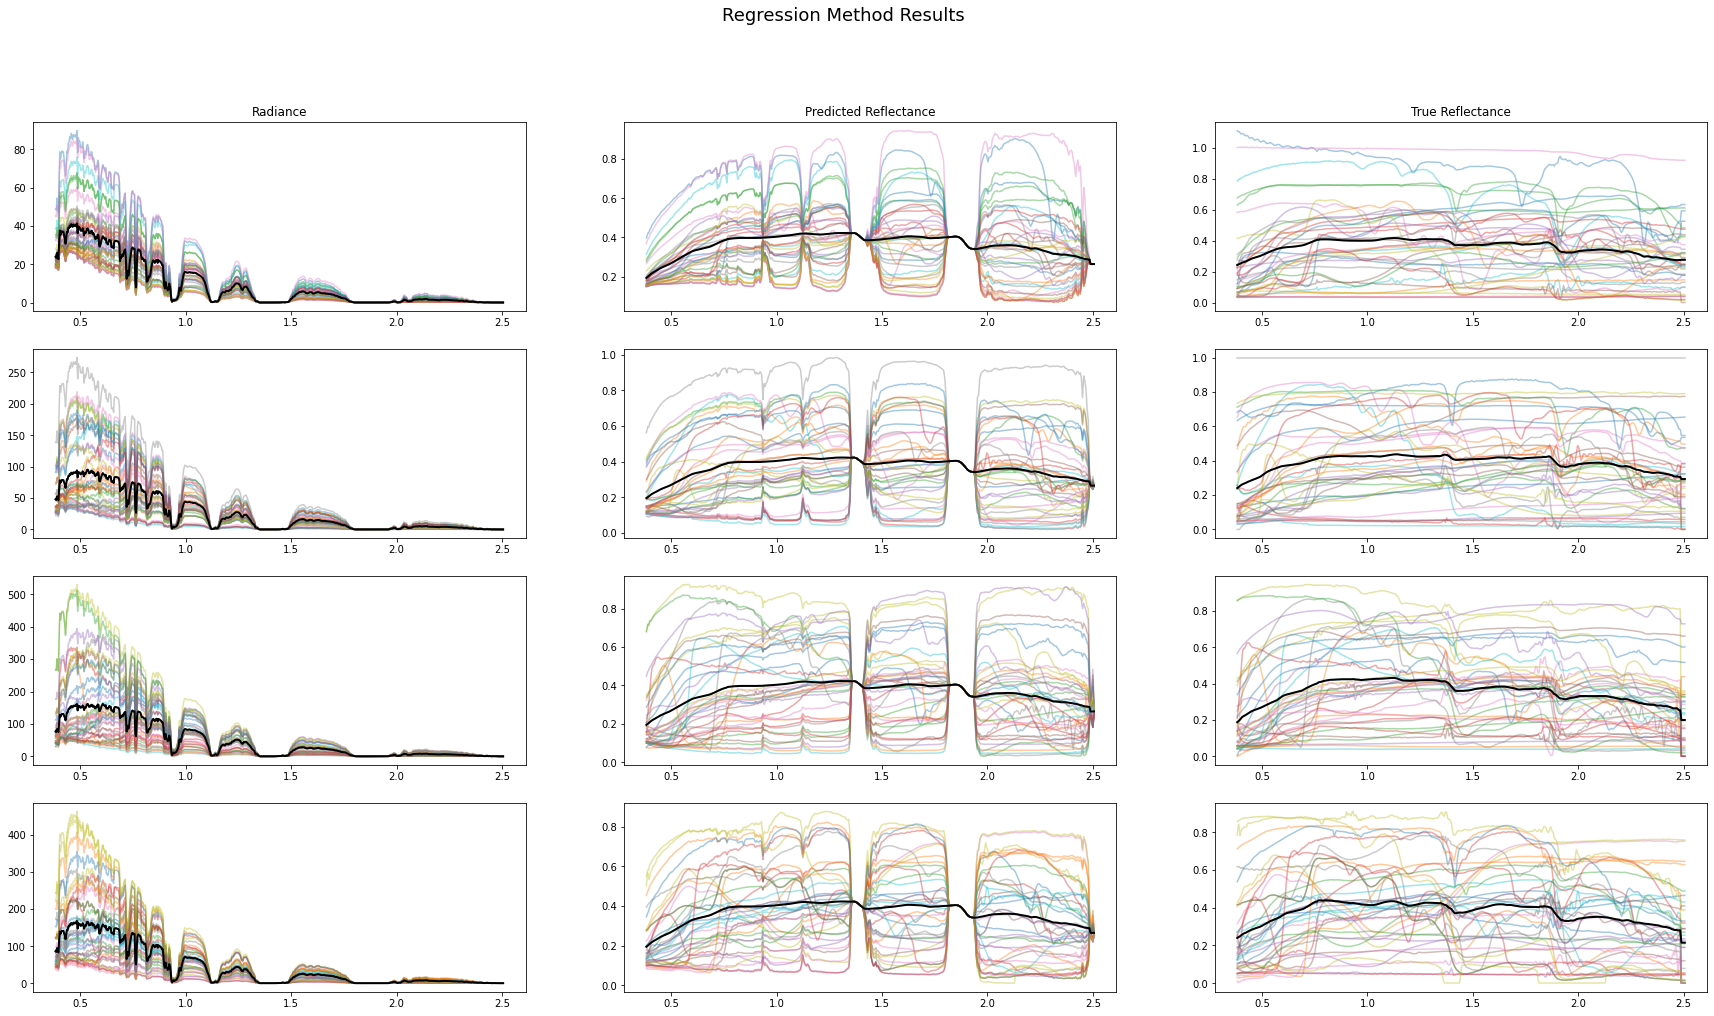

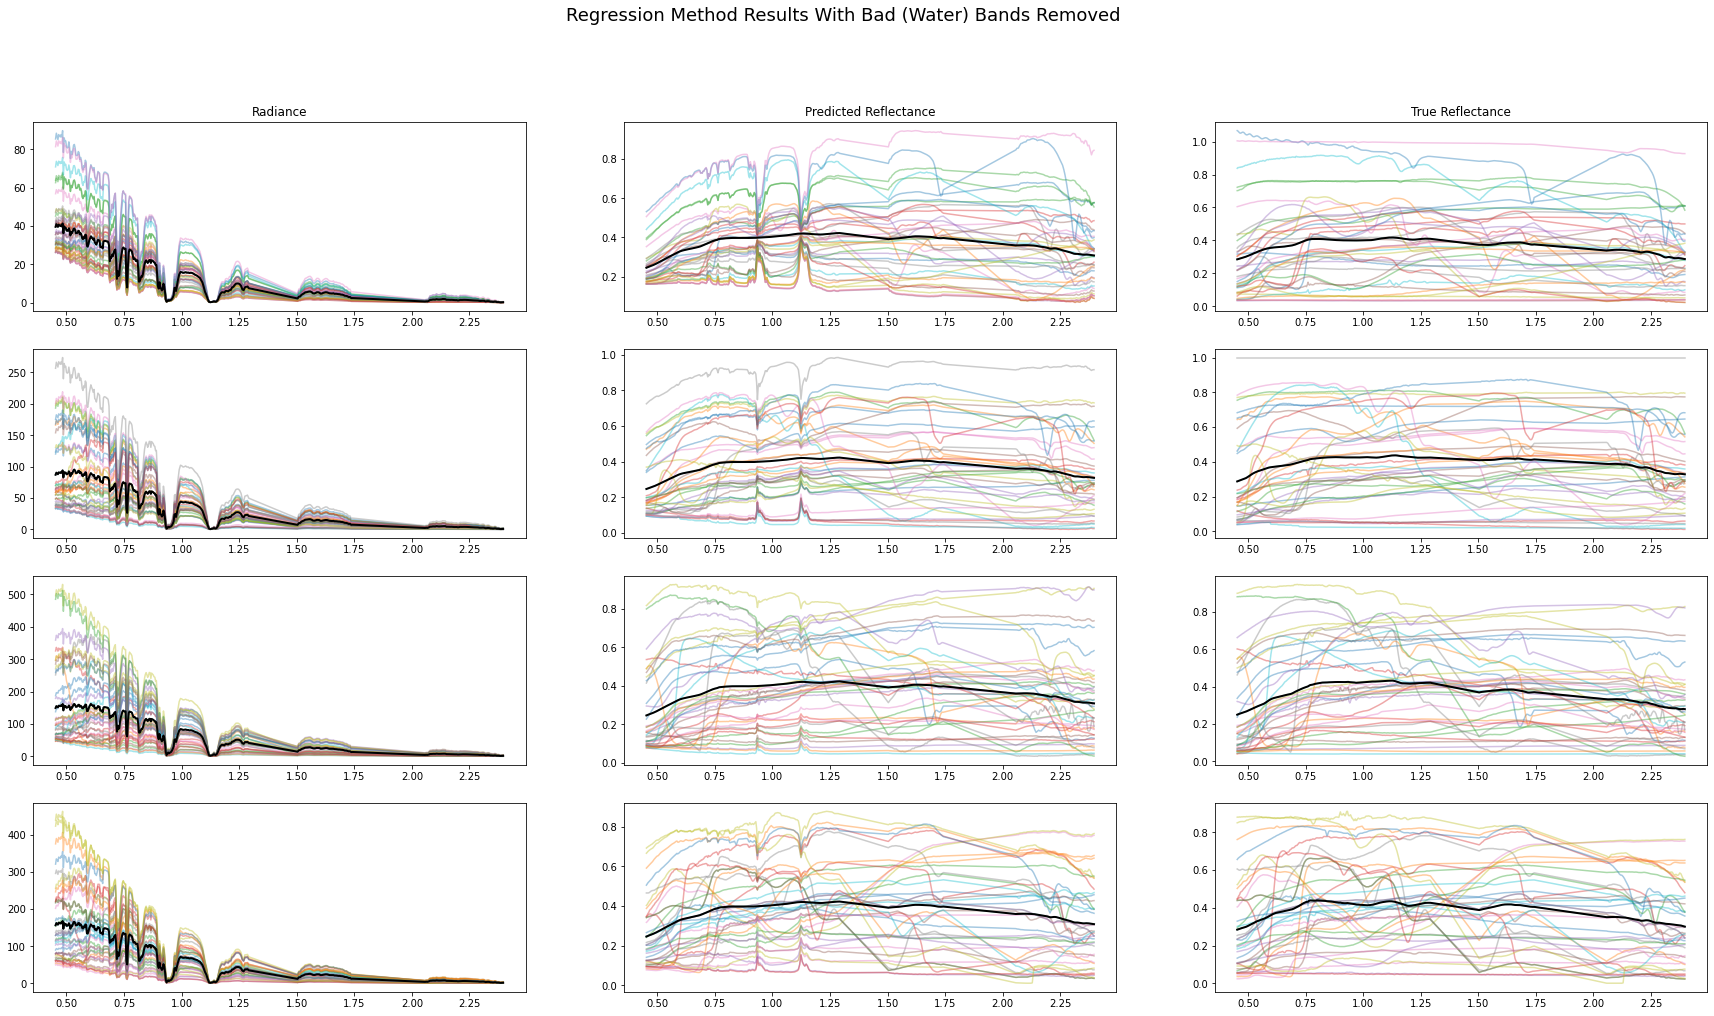

0.8675795959768036
0.29423606186477536


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in true_divide


-inf
nan


/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [39]:
# This is all the 'training' we need
m = np.mean(Y_train[:,nSpec-1,:], axis=0)


class atmComp:
    def __init__(self, m):
        self.m = m
    def predict1(self, x):
        nSpec, nBands = x.shape
        xMean = x[nSpec-1,:]
        gain = self.m/xMean
        y = np.zeros((nSpec, nBands))
        for idx in range(nSpec):
            y[i,:] = x*gain
    def predict(self, Xdata):
        nData, nSpec, nBands = Xdata.shape
        Ydata = np.zeros((nData, nSpec, nBands))
        for i in range(nData):
            xMean = Xdata[i,nSpec-1,:].flatten()
            gain = self.m/xMean
            for specIdx in range(nSpec):
                Ydata[i,specIdx,:] = Xdata[i,specIdx,:]*gain
        return Ydata



model = atmComp(m)

plt.plot(wl,m)
plt.title('The Ideal Mean Reflectance')
plt.show()


# Run the model - there is no training other than computing the 'ideal mean reflectance' m
# Making copies so we don't mess up the origonal data when removing bad bands
test_X = copy.deepcopy(X_test)
test_Y = copy.deepcopy(Y_test)
test_X_reflectance = model.predict(test_X) # predict

# Visualize test images with their denoised images
rows = 4  # defining no. of rows in figure
cols = 3  # defining no. of colums in figure
f = plt.figure(figsize=(10 * cols, 2 * rows * 2))  # defining a figure
for i in range(rows):
    f.add_subplot(4,3,i*cols+1)  # adding sub plot to figure on each iteration
    #plt.imshow(test_images[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_X[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_X[i,nSpec-1,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('Radiance')

    f.add_subplot(4,3,i*cols+2)  # adding sub plot to figure on each iteration
    #plt.imshow(test_desnoised[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_X_reflectance[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_X_reflectance[i,nSpec-1,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('Predicted Reflectance')

    f.add_subplot(4,3,i*cols+3)  # adding sub plot to figure on each iteration
    #plt.imshow(test_desnoised[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_Y[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_Y[i,nSpec-1,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('True Reflectance')

f.suptitle("Regression Method Results", fontsize=18)
plt.savefig("test_results_regression_method.png")

plt.show()




# Define regions to remove
regions = [[0,0.45],[1.3,1.5],[1.75,2.05], [2.4,3]] # remove the low-signal extremes and water bands
for r in regions:
    # get the range of wavelengths for bands to remove
    idx_start = np.argmin(np.abs(np.asarray(wl) - r[0]))
    idx_end = np.argmin(np.abs(np.asarray(wl) - r[1]))
    # remove the bands
    wl = np.delete(wl, range(idx_start, idx_end+1))
    test_X = np.delete(test_X, range(idx_start, idx_end+1), axis=2)
    test_Y= np.delete(test_Y, range(idx_start, idx_end+1), axis=2)
    test_X_reflectance= np.delete(test_X_reflectance, range(idx_start, idx_end+1), axis=2)

# Visualize test images with their denoised images
rows = 4  # defining no. of rows in figure
cols = 3  # defining no. of colums in figure
nBands = len(wl)
f = plt.figure(figsize=(10 * cols, 2 * rows * 2))  # defining a figure
for i in range(rows):
    f.add_subplot(4,3,i*cols+1)  # adding sub plot to figure on each iteration
    #plt.imshow(test_images[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_X[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_X[i,nSpec-1,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('Radiance')

    f.add_subplot(4,3,i*cols+2)  # adding sub plot to figure on each iteration
    #plt.imshow(test_desnoised[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_X_reflectance[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_X_reflectance[i,nSpec-1,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('Predicted Reflectance')

    f.add_subplot(4,3,i*cols+3)  # adding sub plot to figure on each iteration
    #plt.imshow(test_desnoised[i * cols + j].reshape([28, 28]), cmap="Reds")
    plt.plot(wl, test_Y[i].reshape([nSpec,nBands]).T, alpha=0.4)
    plt.plot(wl, test_Y[i,nSpec-1,:].flatten(), color='k', linewidth=2)
    if i==0: plt.title('True Reflectance')

f.suptitle("Regression Method Results With Bad (Water) Bands Removed", fontsize=18)
plt.savefig("test_results_regression_method_bbr.png")

plt.show()

def cor(test_X_reflectance, test_Y, i, j):
    return np.corrcoef(test_Y[i,j].flatten(),test_X_reflectance[i,j].flatten())[0,1]

num_imgs = X_test.shape[0]
correlations = np.zeros(num_imgs*(nSpec-1))
for i in range(num_imgs):
    for j in range(nSpec-1):
        correlations[i*(nSpec-1)+j] = cor(test_X_reflectance, test_Y, i, j)
print(np.mean(correlations))
print(np.std(correlations))



def pdiff(test_X_reflectance, test_Y, i, j):
    return np.mean((test_Y[i,j].flatten() - test_X_reflectance[i,j].flatten())/test_Y[i,j].flatten())
pctDifferencess = np.zeros(num_imgs*(nSpec-1))
for i in range(num_imgs):
    for j in range(nSpec-1):
        pctDifferencess[i*(nSpec-1)+j] = pdiff(test_X_reflectance, test_Y, i, j)
print(np.mean(pctDifferencess))
print(np.std(pctDifferencess))